# Replicating Gniadecka et al.'s paper

In [1]:
import scipy.io as scio
import numpy as np 
import torch
import torch.nn as nn
import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

#### Networks

<b>Neural classifier for binary class data - nc_binclass</b>

The algorithm implements a two layer feed-forward neural network with a hypebolic tangent function for the hidden layer and a logistic sigmoidal function for the output layer. The logistic function makes it possible to interpreted the output as probabilities. The cost function for optimizing the weights is a minimum posterior; cross-entropy error function augmented with a Gaussian prior over the weights. The regularization is determined by MacKay's ML-II scheme.



In [16]:
class FeedForward(nn.Module):
    def __init__(self,num_layers,layer_size):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(20, layer_size) 
        
        if num_layers == 2:
            self.feedforward = nn.Sequential(
                nn.ReLU()
            )
        elif num_layers == 3:
            self.feedforward = nn.Sequential(
                nn.ReLU(),
                nn.Linear(layer_size, layer_size),
                nn.ReLU()
            )
        elif num_layers == 4:
            self.feedforward = nn.Sequential(
                nn.ReLU(),
                nn.Linear(layer_size, layer_size),
                nn.ReLU(),
                nn.Linear(layer_size, layer_size),
                nn.ReLU()
            )
        elif num_layers == 5:
            self.feedforward = nn.Sequential(
                nn.ReLU(),
                nn.Linear(layer_size, layer_size),
                nn.ReLU(),
                nn.Linear(layer_size, layer_size),
                nn.ReLU(),
                nn.Linear(layer_size, layer_size),
                nn.ReLU()
            )
        
        self.fc2 = nn.Linear(layer_size, 2)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        output = self.fc1(x)
        output = self.feedforward(output)
        output = self.fc2(output)   
        output = self.softmax(output)
        return output

In [39]:
def train_model(model, data, target, learning_rate=0.01, num_epochs=500):
    # Reshape data
    tensor_X = torch.Tensor(data)
    tensor_y = torch.Tensor(target).long()

    dataset = torch.utils.data.TensorDataset(tensor_X, tensor_y)

    data_loader = torch.utils.data.DataLoader(dataset, batch_size=None,
                  sampler=torch.utils.data.BatchSampler(torch.utils.data.RandomSampler(dataset), batch_size=50000, drop_last=False))

    # Train model
    criterion = nn.CrossEntropyLoss() 
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    model.train();

    loss_history = []
    for _ in tqdm.trange(num_epochs):
        for _, (inputs, targets) in enumerate(data_loader):
                optimizer.zero_grad()
                y_pred = model(inputs)
                loss = criterion(y_pred, targets)
                loss.backward()
                optimizer.step()
                loss_history.append(loss.item())
        
    return model

In [4]:
def test_model(model, data):
    (x,y,w,h) = data
    tensor_X = torch.Tensor(x)
    
    # Evaluate model
    model.eval();
    y_pred = model(tensor_X) 
            
    approx =[]
    for item in y_pred:
        array = item.detach().numpy()
        index = np.argmax(array)
        approx.append(index)

    target_map = np.zeros((w,h))
    approx_map = np.zeros((w,h))

    for i in range(w):
        for j in range(h):
            index = i*h + j
            target_map[i,j] = y[index]
            approx_map[i,j] = approx[index]

    _, axs = plt.subplots(1,2, figsize=(10,5))
    axs[0].imshow(target_map)
    axs[1].imshow(approx_map)

### Workflow

In [5]:
### DATA ###
tissue3 = scio.loadmat('../Data/tissue3_1.mat')
tissue6 = scio.loadmat('../Data/tissue6.mat')
tissue30 = scio.loadmat('../Data/tissue30.mat')
tissue31 = scio.loadmat('../Data/tissue31.mat')
tissue34_1 = scio.loadmat('../Data/tissue34_1.mat')
tissue34_2 = scio.loadmat('../Data/tissue34_2.mat')
tissue36 = scio.loadmat('../Data/tissue36.mat')
tissue37 = scio.loadmat('../Data/tissue37.mat')
tissue39_1 = scio.loadmat('../Data/tissue39_1.mat')

calibration = scio.loadmat('../Data/cal_14.mat')
x = calibration['Cal'][0][0][0]
x = [item for sublist in x for item in sublist]

In [27]:
tissue_data = [tissue3,tissue6,tissue30,tissue31,tissue34_1,tissue34_2,tissue36,tissue37,tissue39_1]
file_names = ['map_t3_nobl.txt','map_t6_nobl.txt','map_t30_nobl.txt','map_t31_nobl.txt','map_t34_1_nobl.txt','map_t34_2_nobl.txt','map_t36_nobl.txt','map_t37_nobl.txt','map_t39_1_nobl.txt']
tissues = []

count = 0
for item in tissue_data: 
    t_target = item['bcc']
    width = t_target.shape[0]
    height = t_target.shape[1]
    t_map = np.loadtxt(file_names[count]).reshape(width*height,1024)
    t_target = t_target.reshape(width*height)
    tissues.append((t_map,t_target,width,height))
    count += 1

In [28]:
## Take every 10th spectrum 
# We have a total of 520000 spectra -> /10 -> 52000
pca_training_data   = np.zeros((52000,1024))
pca_training_target = []

model_training_data = np.zeros((52000,1024))
model_training_target = []
count = 0

for (t_map,t_target,_,_) in tissues:
    for i in range(len(t_map)):
        if i%10 == 0:
            pca_training_data[count] = t_map[i,:]
            pca_training_target.append(t_target[i])
        if i%10 == 5:
            model_training_data[count] = t_map[i,:]
            model_training_target.append(t_target[i])
            count += 1

In [29]:
norm_data = normalize(pca_training_data)
pca = PCA(n_components=20)
pca.fit(norm_data)

PCA(n_components=20)

In [30]:
for i in range(len(tissues)): 
    transformed = pca.transform(tissues[i][0])
    tissues[i] = (transformed,tissues[i][1],tissues[i][2],tissues[i][3])

model_training_data = pca.transform(model_training_data)

## Test parameters of model

In [33]:
def train_test_model(lr,num_layers,layer_size,epochs):
    ### Create model ###
    model = FeedForward(num_layers,layer_size) 
    
    ### Train model ###
    train_model(model, model_training_data, model_training_target, lr, epochs)
    
    ### Test model ###
    for tissue in tissues:
        test_model(model, tissue)

100%|██████████| 1000/1000 [00:33<00:00, 29.70it/s]


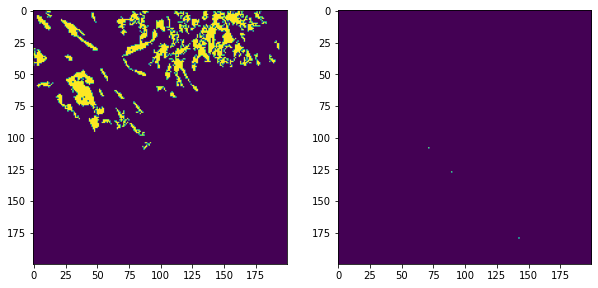

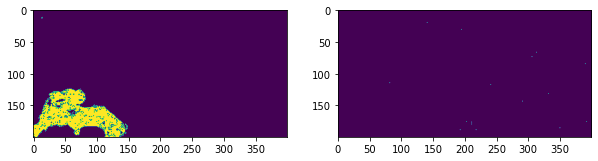

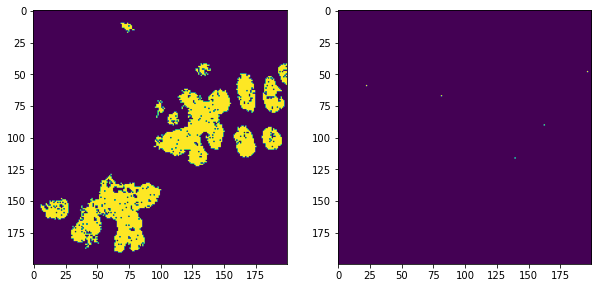

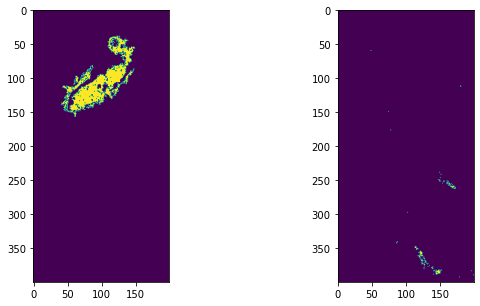

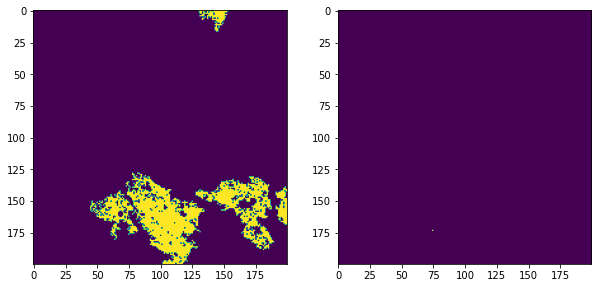

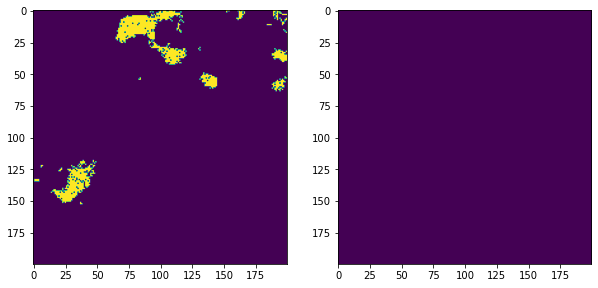

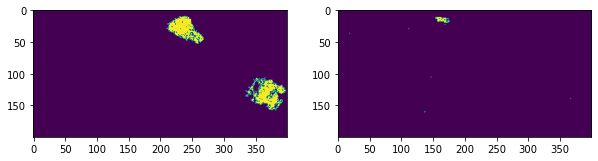

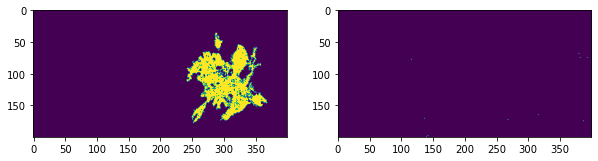

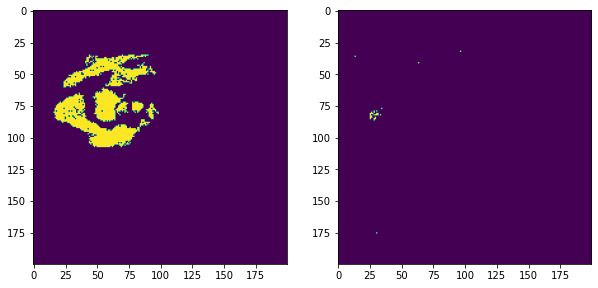

In [42]:
LR = 0.01
NUM_LAYERS = 2
LAYER_SIZE = 10
EPOCHS = 1000
train_test_model(LR,NUM_LAYERS,LAYER_SIZE,EPOCHS)